# Supervised machine learning: Introduction and regularization 
## Binary classification with text data

# Imports

In [1]:
## load packages 
import pandas as pd
import re
import numpy as np
import plotnine
from plotnine import *
import pickle

## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random

pd.set_option('display.max_colwidth', None)

In [2]:
## function to process text
def processtext(one_str, stop_list):
    
    ## remove stopwords
    no_stop = [tok for tok in wordpunct_tokenize(one_str)
              if tok not in stop_list]
    
    
    processed_string = " ".join([porter.stem(i.lower()) 
                        for i in no_stop if 
                        i.lower().isalpha() and len(i) >=3])
    return(processed_string)

## function to create dtm
def create_dtm(list_of_strings, metadata):
    vectorizer = CountVectorizer(lowercase = True)
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), columns=vectorizer.get_feature_names_out())
    dtm_dense_named_withid = pd.concat([metadata.reset_index(), dtm_dense_named], axis = 1)
    return(dtm_dense_named_withid)

# Load data

Load labeled yelp data in `public_data` and run below code

**Note**: make sure to change your path if you need to; if you're having trouble loading the `pkl`, try running on jupyter hub since it may be a python versioning issue

In [3]:
yelp = pd.read_pickle("../../public_data/yelp_forML.pkl")
yelp.head()

,metadata_rowid,metadata_label,raw_text
0,0,0,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
1,1,1,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life."
2,2,0,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money."
3,3,0,"I'm writing this review to give you a heads up before you see this Doctor. The office staff and administration are very unprofessional. I left a message with multiple people regarding my bill, and no one ever called me back. I had to hound them to get an answer about my bill. \n\nSecond, and most important, make sure your insurance is going to cover Dr. Goldberg's visits and blood work. He recommended to me that I get a physical, and he knew I was a student because I told him. I got the physical done. Later, I found out my health insurance doesn't pay for preventative visits. I received an $800.00 bill for the blood work. I can't pay for my bill because I'm a student and don't have any cash flow at this current time. I can't believe the Doctor wouldn't give me a heads up to make sure my insurance would cover work that wasn't necessary and was strictly preventative. The office can't do anything to help me cover the bill. In addition, the office staff said the onus is on me to make sure my insurance covers visits. Frustrating situation!"
4,4,1,"All the food is great here. But the best thing they have is their wings. Their wings are simply fantastic!! The \""Wet Cajun\"" are by the best & most popular. I also like the seasoned salt wings. Wing Night is Monday & Wednesday night, $0.75 whole wings!\n\nThe dining area is nice. Very family friendly! The bar is very nice is well. This place is truly a Yinzer's dream!! \""Pittsburgh Dad\"" would love this place n'at!!"


In [4]:
## preprocess data to create dtm
porter = PorterStemmer()
list_stopwords = stopwords.words("english")

yelp['process_text'] = [processtext(one_review, stop_list = list_stopwords) 
                        for one_review in yelp['raw_text']]

yelp_dtm = create_dtm(yelp['process_text'], yelp[['metadata_label', 'metadata_rowid',
                                                 'process_text', 'raw_text']])

# 1. Split into features, labels, and split into training/hold out

## 1.1 Split into X (features or id metadata) and y (labels)

In [5]:
X = yelp_dtm[[col for col in yelp_dtm.columns if col not in ['metadata_label',
                                                            'index']]].copy()
y = yelp_dtm[['metadata_label']]

In [6]:
## checking dimensionality
X.shape
y.shape

assert X.shape[0] == y.shape[0]
assert y.shape[1] == 1


(15000, 23439)

(15000, 1)

## 1.2 using automatic function to create train-test split

In [7]:
### using built-in function
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2,
                                                   random_state = 221)

## 1.3 using more manual approach to create train-test split

In [8]:
### more manually: useful when we want more control
### over the ids (eg clustering or time ordering)
### or if we want to go back to matrix before preprocessing
nrows_train = round(X.shape[0]*0.8)
nrows_test = X.shape[0] - nrows_train
random.seed(221)
train_ids = random.sample(set(X['metadata_rowid']), nrows_train)

def my_split(train_ids, id_col):
    
    ## get test ids
    test_ids = set(X[id_col]).difference(train_ids)
    
    ## split
    X_train_man = X[X[id_col].isin(train_ids)].copy()
    X_test_man = X[X[id_col].isin(test_ids)].copy()
    y_train_man = y[y.index.isin(train_ids)].iloc[:, 0].to_numpy()
    y_test_man = y[y.index.isin(test_ids)].iloc[:, 0].to_numpy()
    
    ## return
    return(X_train_man, X_test_man, y_train_man, y_test_man)

/tmp/ipykernel_1329413/2529198732.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.


In [9]:
X_train_man, X_test_man, y_train_man, y_test_man = my_split(train_ids, 
                                                           'metadata_rowid')

# 2. Estimate models with hardcoded parameters: logistic regression with L1 regularization (Lasso)

## 2.1 Estimate model using training data

In [10]:

non_feat = ['metadata_rowid', 'raw_text', 'process_text']
logit_lasso = LogisticRegression(penalty = "l1",max_iter=100, 
             C = 0.01, solver='liblinear')
logit_lasso.fit(X_train_man[[col for col in X_train.columns if col not in 
                   non_feat]], y_train_man)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

## 2.2 Generate predictions in test data

In [11]:
y_pred = logit_lasso.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
y_predprob = logit_lasso.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

In [12]:
## print the results 
y_pred[0:10]
y_predprob[0:10]


array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0])

array([[0.64281134, 0.35718866],
       [0.69707576, 0.30292424],
       [0.06363116, 0.93636884],
       [0.72133164, 0.27866836],
       [0.50410001, 0.49589999],
       [0.44378711, 0.55621289],
       [0.10251608, 0.89748392],
       [0.25688334, 0.74311666],
       [0.53072478, 0.46927522],
       [0.52099209, 0.47900791]])

## 2.3 Clean up predictions and calculate error metrics

,y_pred_binary,y_pred_continuous,y_true
656,0,0.240219,0
825,1,0.698148,1
1641,1,0.790647,1
2249,1,0.535208,1
1080,0,0.448088,0
2490,0,0.432732,1
2857,1,0.679522,1
1160,1,0.681765,1
1061,1,0.519458,0
2255,0,0.192997,0


/opt/conda/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.


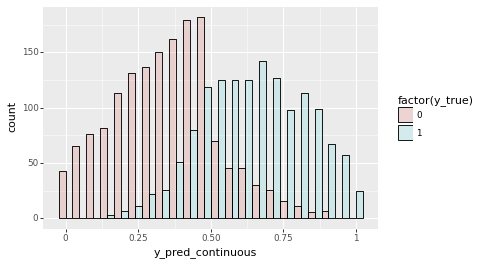

<ggplot: (8739101079279)>

In [13]:
## make into a dataframe
y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})
y_pred_df.sample(n = 10, random_state = 4484)

## plot prob versus true
(ggplot(y_pred_df, aes(x = 'y_pred_continuous', group = 'factor(y_true)',
                      fill = 'factor(y_true)')) +
geom_histogram(alpha = 0.2, position = "dodge", color = 'black'))


In [14]:
## precision as tp / tp+fp 
error_cond = [(y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 1),
             (y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 0),
              (y_pred_df['y_true'] == 0) & (y_pred_df['y_pred_binary'] == 0)]

error_codeto = ["TP", "FN", "TN"]

y_pred_df['error_cat'] = np.select(error_cond, error_codeto, default = "FP")
y_error = y_pred_df.error_cat.value_counts().reset_index()
y_error
y_error.columns = ['cat', 'n']

### precision
print("Precision is:-----------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FP", 'n'].iloc[0])

### recall
print("Recall is:---------------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FN", 'n'].iloc[0])

,index,error_cat
0,TN,1320
1,TP,1103
2,FN,319
3,FP,258


Precision is:-----------


0.8104335047759

Recall is:---------------


0.7756680731364276

## 2.4 Interpret the model

In [15]:
## get top features
las_coef = pd.DataFrame({'coef': logit_lasso.coef_[0],
                         'feature_name': 
                        [col for col in X_train.columns if col not in non_feat]})
las_coef.sort_values(by = 'coef', ascending = False)


top_feat = las_coef.sort_values(by = 'coef', ascending = False)[0:10]
top_feat_list = top_feat.feature_name.to_list()

all_agg = [yelp_dtm.groupby(['metadata_label']).agg({one_feat: np.mean})
for one_feat in top_feat_list]
all_agg_df = pd.concat(all_agg, axis = 1)
all_agg_df

,coef,feature_name
5009,0.839776,delici
8170,0.780793,great
11104,0.614063,love
526,0.445021,amaz
6510,0.399757,excel
...,...,...
20768,-0.303374,terribl
21101,-0.309589,told
14032,-0.362120,noth
1251,-0.381781,bad


,delici,great,love,amaz,excel,best,favorit,friendli,definit,alway
metadata_label,,,,,,,,,,
0,0.026424,0.171178,0.085976,0.022944,0.018819,0.103506,0.027713,0.067672,0.059036,0.113302
1,0.162248,0.557305,0.284452,0.104529,0.093621,0.219691,0.116819,0.169014,0.142640,0.242613


# 3. Comparing perf across diff hyperparameters: logistic regression with L1 regularization (Lasso)

In [16]:
c_list = np.linspace(4, 0.0001, 10)

## define function that takes in one cost parameter
## and estimates model, returning pred
def one_las(one_c):
    one_lasso = LogisticRegression(penalty = "l1", max_iter=100, 
             C = one_c, solver='liblinear')
    one_lasso.fit(X_train_man[[col for col in X_train.columns if 
                              col not in non_feat]], y_train_man)
    y_pred = one_lasso.predict(X_test_man[[col for col in X_test_man.columns 
                if col not in non_feat]])
    y_pred_df = pd.DataFrame({'y_pred': y_pred, 
                             'y_true': y_test_man,
                             'cost': one_c})
    return(y_pred_df)

ESTIMATE_MODEL = True
if ESTIMATE_MODEL == True:
    all_pred = [one_las(one_c) for one_c in c_list]
    with open('../../public_data/lasso_iterate.pkl', 'wb') as handle:
        pickle.dump(all_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('../../public_data/lasso_iterate.pkl', 'rb') as handle:
        all_pred = pickle.load(handle)

In [17]:
## bind into one dataframe 
all_pred_df = pd.concat(all_pred)
all_pred_df.head()
## score one cost level 
def score_onedf(one_c, all_c):
    one_df = all_c[all_c.cost == one_c].copy()
    prec_onec =  precision_score(
        one_df['y_true'], one_df['y_pred'],
        zero_division = 0)
    return(prec_onec)
    
all_score = pd.DataFrame({'cost': c_list,
                         'precision': [score_onedf(one_c, all_pred_df) 
                                  for one_c in c_list]})
all_score

all_score[all_score.precision == np.max(all_score.precision)]

,y_pred,y_true,cost
0,0,0,4.0
1,0,0,4.0
2,1,1,4.0
3,0,0,4.0
4,0,0,4.0


,cost,precision
0,4.000000,0.860594
1,3.555567,0.861284
2,3.111133,0.860096
3,2.666700,0.863260
4,2.222267,0.863983
5,1.777833,0.860401
6,1.333400,0.861188
7,0.888967,0.864232
8,0.444533,0.867495
9,0.000100,0.000000


,cost,precision
8,0.444533,0.867495


# 4. Activity 

- Read the documentation here to initialize a ridge regression (l2 penalty)- you can use the same cost parameter (C) and number of iterations as in the lasso example above: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Fit the model on X_train_man, y_train_main 
- Generate binary and continuous predictions
- Create a function that takes in a dataframe of binary predictions and true labels and manually calculates the $F_{1}$ score:

$$F_{1} = 2 * \dfrac{precision * recall}{precision + recall} = \dfrac{TP}{TP + 0.5(FP + FN)}$$

- Apply that function to calculate the F1 score for the decision tree and lasso (from above), and ridge regression (from the activity)
- *Challenge exercise*: parametrize the model fitting with a function that takes in a classifier as an argument and returns coefficients or feature importances and certain eval metrics (eg precision, recall, and F1)

In [18]:
# your code here 
logit_ridge = LogisticRegression(penalty = "l2",max_iter=100, 
             C = 1, solver='liblinear')

X_feat_tr = X_train_man[[col for col in X_train_man.columns 
                if col not in non_feat]]
X_feat_te = X_test_man[[col for col in X_test_man.columns 
                if col not in non_feat]]
logit_ridge.fit(X_feat_tr, y_train_man)
## predict
y_hat = logit_ridge.predict(X_feat_te)
    


LogisticRegression(C=1, solver='liblinear')

In [19]:
def calc_myF1(fit_classifier, X_test, y_test):
    
    ## predict
    y_hat = fit_classifier.predict(X_test)
    
    ## get the relevant counts
    df_pred = pd.DataFrame({'y_true': y_test,
                           'y_pred_binary': y_hat})
    
    ## counts of diff metrics
    tp = df_pred[(df_pred.y_true == 1) &
            (df_pred.y_pred_binary == 1)].shape[0]
    fp = df_pred[(df_pred.y_true == 0) &
            (df_pred.y_pred_binary == 1)].shape[0]
    fn = df_pred[(df_pred.y_true == 1) &
            (df_pred.y_pred_binary == 0)].shape[0]
    
    ## combine
    f1 = (tp)/(tp + 0.5*(fp + fn))
    
    ## return
    return(f1)


In [20]:
calc_myF1(logit_ridge, X_test = X_feat_te, y_test = y_test_man)
calc_myF1(logit_lasso, X_test = X_feat_te, y_test = y_test_man)


0.8745220716023636

0.7926697808120733

In [21]:
ridge_c = pd.DataFrame({'coef': logit_ridge.coef_[0],
                        'feat': X_feat_tr.columns})

ridge_c[ridge_c.coef != 0].head()
ridge_c.sort_values(by = 'coef', ascending = False)

,coef,feat
0,0.005291,aaa
1,-0.001103,aaaaaa
2,0.000004,aaaaaaaaaaaaaaand
3,0.000128,aaaaaaaaaaaaahhhhhhhhhhh
4,-0.076687,aaaaand


,coef,feat
5009,1.862923,delici
526,1.815087,amaz
6744,1.800407,fantast
19359,1.766226,solid
6510,1.654128,excel
...,...,...
1880,-2.064684,bland
11696,-2.122132,mediocr
20768,-2.160225,terribl
23108,-2.437169,worst


In [22]:
## ec of iteration- see above example

### Extra challenge

Text vectorization methods affect downstream classification accuracy. Above, we used simple term counts to turn texts into numbers. This time, instead of using term frequencies, use `sklearn`'s `TfidfVectorizer()` function to weight features with term frequency inverse document frequency (TF-IDF): this gives a word greater weight both when it is more frequent in a text AND when it is rare across the corpus. Does this vectorization approach improve classification accuracy?

In [ ]:
# solution
tfidfvec = TfidfVectorizer(stop_words = 'english', min_df = 1, binary=True)
training_dtm_tfidf = tfidfvec.fit_transform(X_train_man.body)
test_dtm_tfidf = tfidfvec.transform(X_test_man.body)

logit = LogisticRegression(solver='liblinear')
logit.fit(training_dtm_tfidf, training_labels)
predictions_tfidf = logit.predict(test_dtm_tfidf) 
accuracy_score(predictions_tfidf, test_labels)